## Project overview PR1.20

The goal of the project is to evaluate how different models perform in the task of topic modelling.
The models used by the authors of the paper are:
1. Latent Dirchlet Allocation (LDA)
2. Latent Semantic Analysis (LSA)
3. Non-Negative Matrix Factorization (NMF)
4. Principal Component Analysis (PCA)
5. Random Projection (RP)

The evaluation performed by the authors consisted in examining models performances when changing the **number of topics** or the **number of words**, keeping all the others parameters fixed.

The authors didn't specify which parameters were fixed while performing evaluation, therefore we had to choose our own settings. 

## Importing and preprocessing
The data used comes from the 20-Newsgroups dataset, available online, containing various texts from different topics. The data required preprocessing steps such as:
- removal of special characters using regular expressions
- tokenization
- lemmatization with the aid of Part Of Speech

Below the code used for importing and preprocessing

```python
import pandas as pd
import os
import re, string
from nltk.corpus import words, wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import word_tokenize
import contractions

```python
def import_data(path):
    data_path = R"data\data-train"
    full_path = os.path.join(path, data_path)
    
    folders_path_list = []
    folders = os.listdir(full_path)
    
    for folder in folders:
        folders_path_list.append(os.path.join(full_path, folder))
    
    conversion = {'religion' : [folders[i] for i in [0, 15, 19]],
                  'computer': [folders[i] for i in range(1, 6)],
                  'science': [folders[i] for i in range(11, 15)],
                  'politics': [folders[i] for i in range(16, 19)],
                  'misc': [folders[6]],
                  'recreation': [folders[i] for i in range(7, 11)]}
    
    topics = folders.copy()
    
    for j, folder in enumerate(folders):
        for topic, values in conversion.items():
            
            if folder in values:
                topics[j] = topic
    
    
    column_names = ['File_Name', 'Content', 'Folder', 'Topic']
    df = pd.DataFrame(columns=column_names)

    for folder, folder_path, topic in zip(folders, folders_path_list, topics):
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            
            with open(file_path, 'r', encoding='latin-1') as file:
                content = file.read()
                df = pd.concat([df,
                                pd.DataFrame({'File_Name': [file_name], 'Content': [content],
                                              'Folder' : [folder], 'Topic': [topic]})],
                               ignore_index=True)
                
    df['Content'] = df['Content'].astype("string")
    
    return df


```python
def preprocess(doc):
    # Tokenize document
    tokens = word_tokenize(doc)
    
    # Expand contractions
    tokens = [contractions.fix(token) for token in tokens]
    
    # Rejoin tokens into a string
    doc = ' '.join(tokens)
    
    # Remove special characters, retain only words with letters
    doc = re.sub(r'[^\w\s\']', '', doc)
    
    # remove digits
    doc = re.sub(r'[0-9]+', '', doc)
    
    # Remove brackets of any kind
    doc = re.sub(r'[(){}[\]]', '', doc)
    
    # Remove punctuation
    doc = doc.translate(str.maketrans("", "", string.punctuation))
    
    # Lowercase and strip
    doc = doc.lower().strip()

    # Tokenize again after cleaning
    cleaned_tokens = word_tokenize(doc)

    # POS tagging on the original tokenized version
    pos_tags = pos_tag(cleaned_tokens)
    
    # map POS tags to WordNet POS tags
    tag_map = {
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV,
        'J': wordnet.ADJ
    }

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token, tag_map.get(pos[0], wordnet.NOUN)) for token, pos in pos_tags]
    
    # Filter stopwords out of lemmatized tokens
    stop_words = stopwords.words('english')
    
    stop_words.extend(['hi', 'thanks', 'lot', 'article', 'everyone',
                       'anyone', 'someone', 'nothing',
                       'something', 'anything', 'everybody', 'somebody', 'anybody',
                       'please', 'ask', 'people', 'university',
                       'question', 'yeah', 'thing', 'sorry', 'hey', 'oh',
                       'thank', 'cannot', 'right', 'would', 'one', 'get',
                       'know', 'like', 'use', 'go',
                       'think', 'make', 'say', 'see', 'also', 'could', 'well', 'want',
                       'way', 'take', 'find', 'need', 'try',
                       'much', 'come', 'many', 'may', 'give', 'really', 'tell',
                       'two', 'still', 'read', 'might', 'write',
                       'never', 'look', 'sure', 'day', 'even', 'new', 'time',
                       'good', 'first', 'keep', 'since', 'last', 
                       'long', 'fact', 'must', 'another', 'little',
                       'without', 'csutexasedu', 'nntppostinghost',
                       'seem', 'replyto', 'let', 'group', 'call', 'seem',
                       'maybe','shall', 'eg', 'etc', 'rather', 'either'])
    
    filtered_tokens = [token for token in lemmatized_tokens if token not in stop_words]
    
    # Recreate the document
    doc = ' '.join(filtered_tokens)
    
    return doc


```python
scripts_path = os.getcwd()
path = os.path.dirname(scripts_path)

df = import_data(path)

df['Clean_Content'] = df['Content'].apply(preprocess)

```python
def check_empty_docs(df):
    # Check for empty documents
    empty_documents = df[df['Clean_Content'].str.strip() == '']

    # Count the number of empty documents
    num_empty_documents = len(empty_documents)

    if num_empty_documents > 0:
        print(f"Number of empty documents: {num_empty_documents}")
        print("Indices of empty documents:")
        print(empty_documents.index)
    else:
        print("No empty documents found.")

```python
check_empty_docs(df['Clean_Content'])
```
No empty documents found.

## TFIDF and other objects
Once the dataset has been imported and preprocessed, a TFIDF matrix was constructed as input matrix for the models. To do this, it was convenient to write another function that could be called inside the notebook. Besides the tfidf matrix, given a specific set of parameters, the function also returned some objects required for topic modelling with the gensim package, which is the one used for some of the models.

```python
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, matutils
from nltk.tokenize import word_tokenize

def get_tfidf_tokendocs_corpus_dict(df, max_df, min_df, max_features):
    # convert text into lists
    documents = df['Clean_Content'].tolist()
    documents

    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(max_df = max_df, min_df = min_df, norm = 'l2', max_features=max_features)
    tfidf_matrix = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()
    
    # this is a list of documents with tokens
    # it's needed for the coherence function
    tokenized_docs = [word_tokenize(document) for document in documents]
    
    # Convert TF-IDF matrix to Gensim corpus
    corpus = matutils.Sparse2Corpus(tfidf_matrix.transpose())
    # Convert the document-term matrix to a gensim Dictionary
    dictionary = corpora.Dictionary.from_corpus(corpus,
                                            id2word=dict((id, word) for word, id in vectorizer.vocabulary_.items()))
    
    return tfidf_matrix, feature_names, tokenized_docs, corpus, dictionary


tfidf_matrix, feature_names, tokenized_docs, corpus, dictionary = get_tfidf_tokendocs_corpus_dict(df, max_df=0.5, min_df=5, max_features=1000)

## Models evaluation
The evaluation of the models was done by comparing Coherence, a measure of topics quality.

Unfortunately, the paper used Precision, Recall and F-Score, but the details of how they were implemented was missing and no other resources were found, therefore the results differ from the ones of the paper.

Nevertheless, we replicated the analysis by comparing the goodness of the models for different number of topics (5, 10, 20, 50) and different number of words (10, 100, 1000, 10000).

To perform the evaluation, we chose to write functions that ran the models different times for the specified parameters.

```python
from gensim.models import LdaModel, LsiModel, CoherenceModel
from sklearn.decomposition import NMF, PCA
from sklearn.random_projection import GaussianRandomProjection
import numpy as np
from scipy import sparse
import os
import matplotlib.pyplot as plt
import seaborn as sns

topics = [5, 10, 20, 50]
words = [10, 100, 1000, 10000]

### Evaluation by topics:
```python
def coherence_by_topics(n: int, corpus, dictionary, texts, feature_names, tfidf):
    models = ['LDA', 'LSA', 'NMF', 'PCA', 'RP']

    coherence = []

    for model_name in models:
        if model_name == 'LDA' or model_name == 'LSA':
            
            if model_name == 'LDA':
                model = LdaModel(corpus=corpus, id2word=dictionary,
                                num_topics = n,
                                alpha='auto', eta='auto', passes=5,
                                random_state=1)
        
            elif model_name == 'LSA':
                model = LsiModel(corpus, id2word=dictionary,
                                num_topics=n, random_seed=1)
            
            coherence_value = CoherenceModel(model=model,
                                            dictionary = dictionary,
                                            texts=texts,
                                            coherence='c_v').get_coherence()
            coherence.append(coherence_value)

        elif model_name == 'NMF' or model_name == 'PCA' or model_name == 'RP':
            
            if model_name == 'NMF':
                
                model = NMF(n_components=n,
                            random_state=1, max_iter=600).fit(tfidf)
                
            elif model_name == 'RP':
                
                model = GaussianRandomProjection(n_components=n,
                                                random_state=1).fit(tfidf)
                
            elif model_name == 'PCA':
                # Convert sparse matrix to dense. PCA cannot be done on sparse matrixes
                tfidf_matrix_dense = tfidf.todense()
                            if sparse.issparse(tfidf) else tfidf

                # Convert to numpy array
                tfidf_matrix_array = np.asarray(tfidf_matrix_dense)

                # Centering
                mean_tfidf = np.mean(tfidf_matrix_array,
                                    axis=0)
                centered_tfidf_matrix = tfidf_matrix_array - mean_tfidf
                
                model = PCA(n_components=n,
                            random_state=1).fit(centered_tfidf_matrix)
                
            # Retrieve top words for each component
            topics = []
            for j, component in enumerate(model.components_):
                component_words = [(feature_names[k], component[k])
                                    for k in component.argsort()[::-1]]
                topics.append(component_words)
                
            topics_for_coherence = [[word for word, _ in topic]
                                        for topic in topics]
            
            coherence_value = CoherenceModel(topics=topics_for_coherence,
                                            texts=texts, dictionary=dictionary,
                                            coherence='c_v').get_coherence()
            coherence_value = round(coherence_value, 4)
            
            coherence.append(coherence_value)
    
    coherence = [round(num, 4) for num in coherence]

    return list(zip(models, coherence))

### Evaluation by words:
```python
def coherence_by_words(df, n):
    models = ['LDA', 'LSA', 'NMF', 'PCA', 'RP']

    documents = df['Clean_Content'].tolist()
    documents

    coherence = []

    for model_name in models:
        # TF-IDF Vectorization
        vectorizer = TfidfVectorizer(max_df = 0.5, min_df = 5,
                                    norm = 'l2', max_features=n)
        tfidf_matrix = vectorizer.fit_transform(documents)
        feature_names = vectorizer.get_feature_names_out()

        # this is a list of documents with tokens
        # it's needed for the coherence function
        texts = [word_tokenize(document) for document in documents]
        
        # Convert TF-IDF matrix to Gensim corpus
        corpus = matutils.Sparse2Corpus(tfidf_matrix.transpose())
        # Convert the document-term matrix to a gensim Dictionary
        dictionary = corpora.Dictionary.from_corpus(corpus,
                                                id2word=dict((id, word)
                                                for word, id in
                                                vectorizer.vocabulary_.items()))
        
        if model_name == 'LDA' or model_name == 'LSA':

            if model_name == 'LDA':
                model = LdaModel(corpus=corpus,
                                id2word=dictionary,
                                num_topics = 5,
                                alpha='auto',
                                eta='auto', passes=5,
                                random_state=1)
        
            elif model_name == 'LSA':
                model = LsiModel(corpus,
                                id2word=dictionary,
                                num_topics=5,
                                random_seed=1)
            
            coherence_value = CoherenceModel(model=model,
                                            dictionary = dictionary,
                                            texts=texts,
                                            coherence='c_v').get_coherence()
            coherence.append(coherence_value)

        elif model_name == 'NMF' or model_name == 'PCA' or model_name == 'RP':
            
            if model_name == 'NMF':
                
                model = NMF(n_components=5,
                            random_state=1,
                            max_iter=600).fit(tfidf_matrix)
                
            elif model_name == 'RP':
                
                model = GaussianRandomProjection(n_components=5,
                                                random_state=1).fit(tfidf_matrix)
                
            elif model_name == 'PCA':
                # Convert sparse matrix to dense. PCA cannot be done on sparse matrixes
                tfidf_matrix_dense = tfidf_matrix.todense()
                                        if sparse.issparse(tfidf_matrix)
                                        else tfidf_matrix

                # Convert to numpy array
                tfidf_matrix_array = np.asarray(tfidf_matrix_dense)

                # Centering with respect to the columns
                mean_tfidf = np.mean(tfidf_matrix_array,
                                    axis=0)
                centered_tfidf_matrix = tfidf_matrix_array - mean_tfidf
                
                model = PCA(n_components=5,
                            random_state=1).fit(centered_tfidf_matrix)
                
            # Retrieve top words for each component
            components = []
            for j, component in enumerate(model.components_):
                component_words = [(feature_names[k], component[k])
                                    for k in component.argsort()[::-1]]
                components.append(component_words)
                
            topics_for_coherence = [[word for word, _ in component]
                                        for component in components]
            
            coherence_value = CoherenceModel(topics=topics_for_coherence,
                                            texts=texts,
                                            dictionary=dictionary,
                                            coherence='c_v').get_coherence()
            coherence_value = round(coherence_value, 4)
            
            coherence.append(coherence_value)
    
    coherence = [round(num, 4) for num in coherence]
        
    return list(zip(models, coherence))

### Storing results
```python
from coherence_by_topics import coherence_by_topics
from coherence_by_words import coherence_by_words

evaluation_by_topics = {}

for n_topics in topics:
    metrics_words = coherence_by_topics(n = n_topics,
                                        corpus=corpus,
                                        dictionary=dictionary,
                                        texts=tokenized_docs,
                                        feature_names=feature_names,
                                        tfidf=tfidf_matrix)
    
    evaluation_by_topics[n_topics] = metrics_words

evaluation_by_words = {}

for n_words in words:
    metrics_words = coherence_by_words(df, n = n_words)
    evaluation_by_words[n_words] = metrics_words

### Summary tables
```python
def tables(evaluation, type: str):
    # Specify the results folder
    results = R"results"
    results_folder = os.path.join(path, results)

    # Create individual DataFrames for each specific number
    dfs = {}
    for n, values in evaluation.items():
        dfs[n] = pd.DataFrame(values, columns=['Model', 'Coherence'])

    for n, df in dfs.items():
        fig, ax = plt.subplots(figsize=(4, 3))  # Adjust the figure size
        ax.axis('off')  # Turn off the axis

        # Set the width of the columns
        col_width = 1.0 / len(df.columns)
        cell_data = [df.columns] + df.values.tolist()  # Include column names as the first row
        table = ax.table(cellText=cell_data, loc='center', cellLoc='center', colLabels=None, edges='open')

        # Make column labels bold
        for (i, j), cell in table.get_celld().items():
            if i == 0:
                cell.set_text_props(fontweight='bold')

        # Adjust column width
        table.auto_set_column_width([0, 1])

        # Adjust the position of the table within the figure
        table.set_fontsize(13)  # Adjust font size
        table.scale(1, 2)  # Scale the table

        ax.set_title(f'Coherence with {n} {type}', fontsize=18, y=0.95)  # Add a title

        filename = os.path.join(results_folder, f'table_{n}_{type}.png')
        plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)  # Adjust padding
        plt.close()  # Close the figure to avoid overlapping when saving multiple files

### By topics
```python
tables(evaluation_by_topics, 'topics')
```

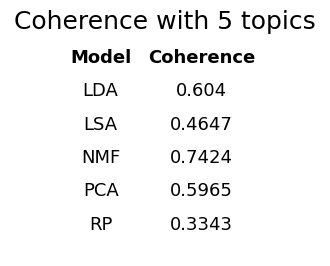
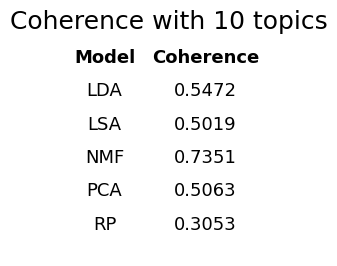
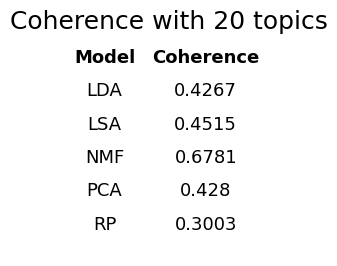
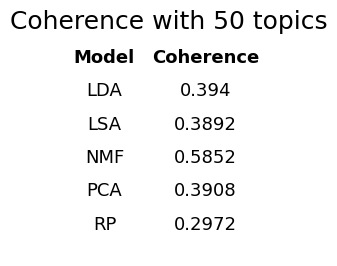

### By words
```python
tables(evaluation_by_words, 'words')
```
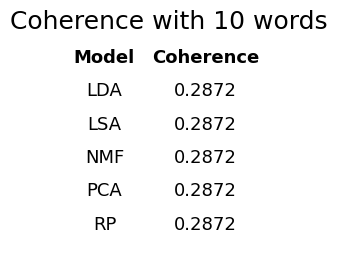
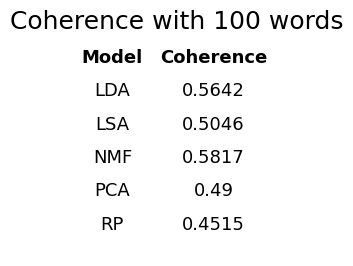
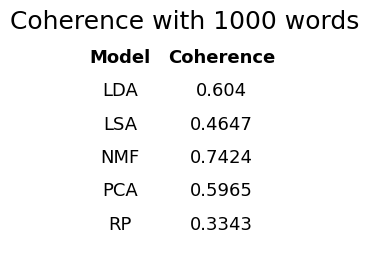
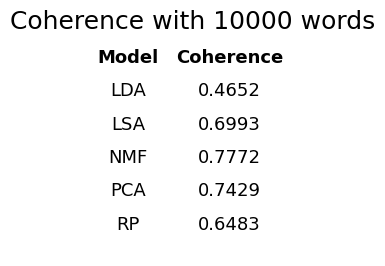

### Summary barplots
```python
def plots(evaluation, type: str):
    figures = R'figures'
    figures_folder = os.path.join(path, figures)
        
    for n, metrics in evaluation.items():
        model_names, coherence_values = zip(*metrics)

        data = {'Model': model_names, 'Coherence Value': coherence_values}
        df = pd.DataFrame(data)

        plt.figure(figsize=(8, 5))
        
        sns.barplot(x='Model', y='Coherence Value', data=df, hue='Model', palette='viridis')
        
        plt.xlabel('Model')
        plt.ylabel('Coherence Value')
        plt.title(f'Coherence Evaluation for {n} {type}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()

        save_path = os.path.join(figures_folder, f'coherence_evaluation_{n}_{type}')
        
        plt.savefig(save_path)
        plt.show()

### By topics
```python
plots(evaluation_by_topics, 'topics')
```
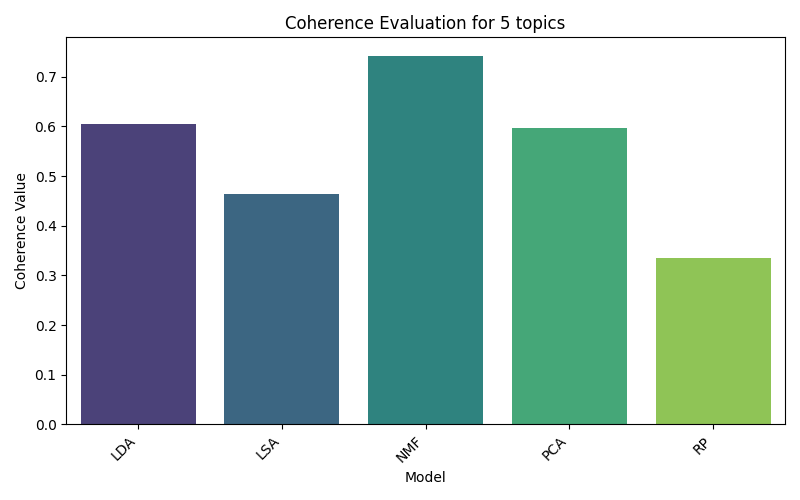
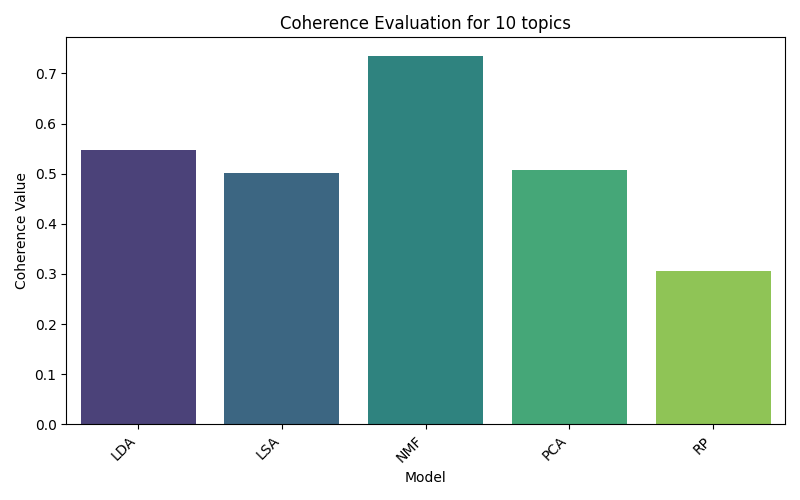
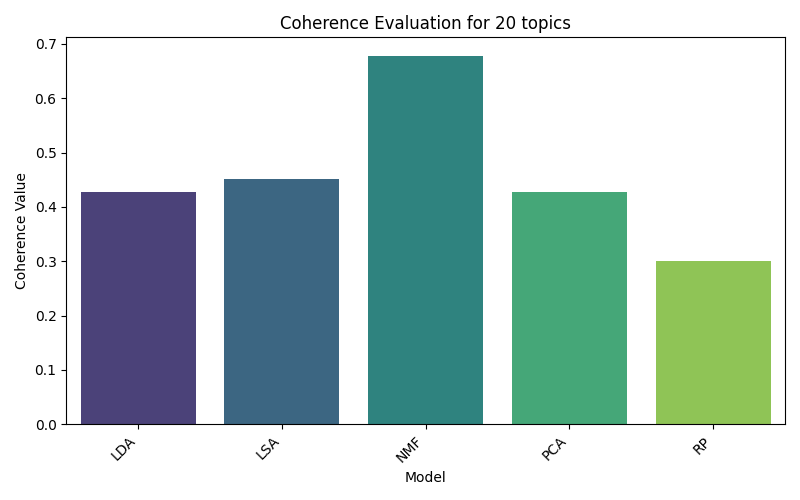
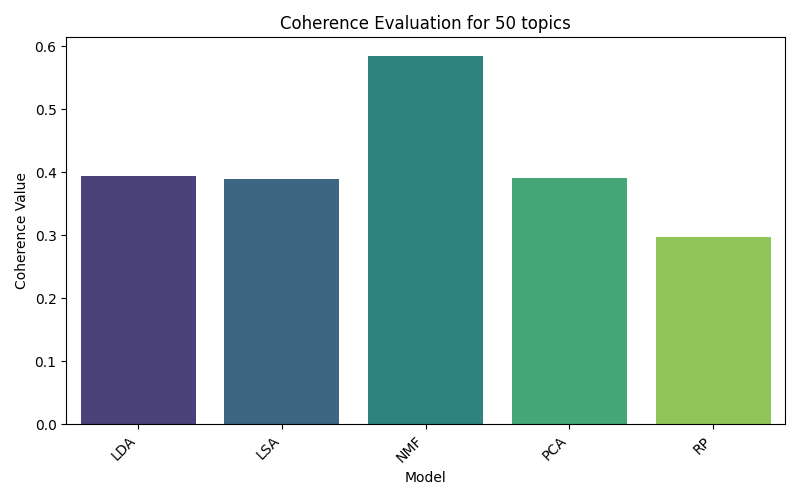

### By words
```python
plots(evaluation_by_words, 'words')
```
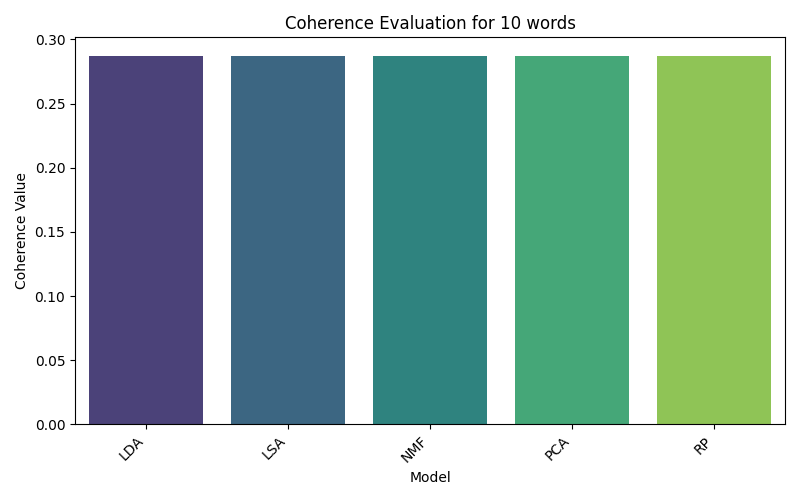
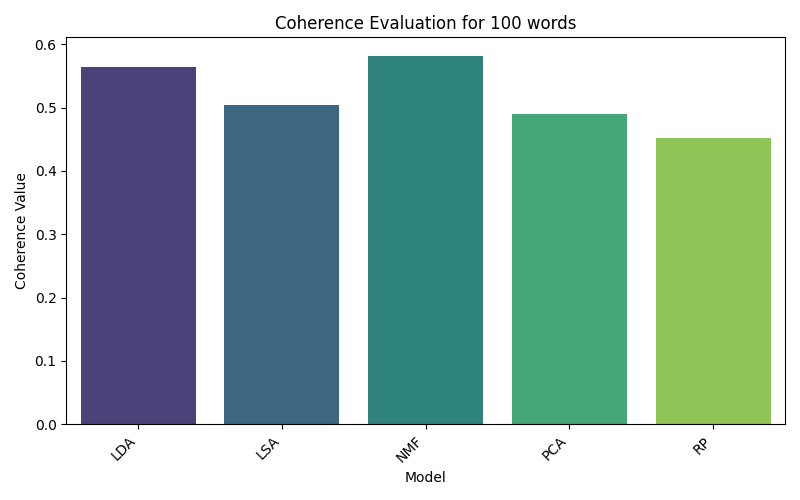
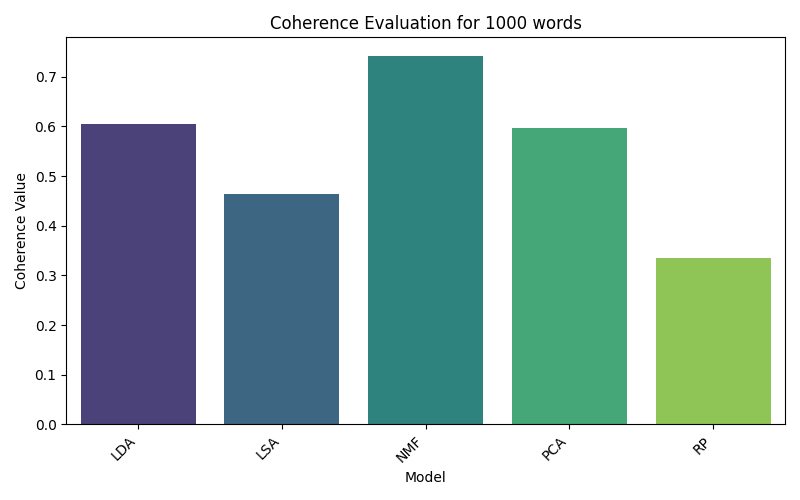
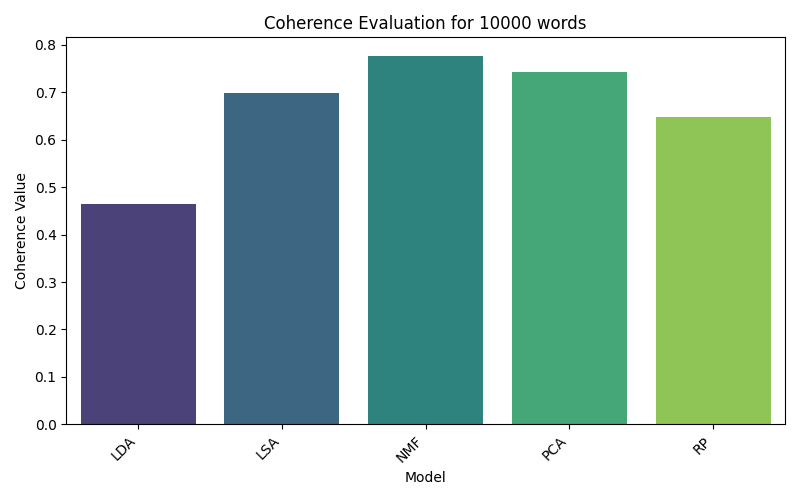

## Model results
In this section we show the results of the various models with 5 topics and 1000 words.
In particular, we print the top 15 words for each topic identified by the model.

Another function has been written to show the results based on the model that was stored

### Display topics
```python
def display_topics(model_name, model, feature_names):
    if model_name == 'LDA' or model_name == 'LSA':
        
        for topic in model.print_topics(num_words=15):
            topic_index, words = topic
            topic_words = [word.split("*")[1].strip().strip('"') for word in words.split(" + ")]
            print(f"Topic {topic_index + 1}: {', '.join(topic_words)}")
            print('\n')

    elif model_name == 'NMF' or model_name == 'PCA' or model_name == 'RP':
        
        for topic_index, component in enumerate(model.components_):
            component_words = [feature_names[k] for k in component.argsort()[::-1]]
            print(f"Topic {topic_index + 1}: {', '.join(component_words[:15])}")
            print('\n')

### LDA Model
```python
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5,
                     alpha='auto', eta='auto', passes=5, random_state=1)

display_topics('LDA', lda_model, feature_names)

Topic 1: government, apr, state, year, law, gun, believe, case, clinton, mean, world, ca, netcomcom, point, opinion

Topic 2: god, israel, armenian, israeli, christian, jew, jesus, turkish, arab, jewish, greek, bible, christ, armenia, kill

Topic 3: gordon, email, space, bank, science, computer, address, post, version, xnewsreader, tin, pl, mail, information, orbit

Topic 4: window, drive, work, system, problem, card, file, sale, program, distribution, run, email, computer, help, software

Topic 5: game, team, player, win, play, hockey, season, year, baseball, fan, playoff, score, nhl, league, toronto

### LSA model
```python
lsi_model = LsiModel(corpus, id2word=dictionary, num_topics=5, random_seed = 1)

display_topics('LSA', lsi_model, feature_names)
```

Topic 1: apr, system, work, year, problem, window, distribution, god, computer, drive, run, file, car, state, world

Topic 2: window, god, file, card, drive, driver, christian, program, jesus, believe, system, email, disk, problem, video

Topic 3: game, team, god, player, win, play, year, season, hockey, christian, jesus, score, baseball, fan, file

Topic 4: window, god, key, chip, file, car, clipper, game, encryption, government, christian, team, jesus, win, program

Topic 5: drive, car, key, file, window, clipper, chip, encryption, scsi, card, sale, god, program, bike, government

### NMF Model
```python
nmf_model = NMF(n_components=5, random_state=1).fit(tfidf_matrix)

display_topics('NMF', nmf_model, feature_names)
```

Topic 1: key, apr, government, state, year, car, gun, chip, system, distribution, law, work, clipper, ca, space

Topic 2: window, file, program, run, version, help, problem, application, image, graphic, driver, email, display, server, manager

Topic 3: game, team, win, player, play, year, season, hockey, score, baseball, fan, nhl, playoff, league, run

Topic 4: god, christian, jesus, believe, bible, christ, faith, church, atheist, life, religion, belief, truth, christianity, sin

Topic 5: drive, card, sale, scsi, mb, disk, monitor, mac, driver, video, system, problem, hard, controller, work

### PCA Model
```python
tfidf_matrix_dense = tfidf_matrix.todense() if sparse.issparse(tfidf_matrix) else tfidf_matrix

# Convert to numpy array
tfidf_matrix_array = np.asarray(tfidf_matrix_dense)

# Centering
mean_tfidf = np.mean(tfidf_matrix_array, axis=0)  # Calculate the mean of each column
centered_tfidf_matrix = tfidf_matrix_array - mean_tfidf

pca_model = PCA(n_components=5, random_state=1).fit(centered_tfidf_matrix)

display_topics('PCA', pca_model, feature_names)
```

Topic 1: god, christian, jesus, believe, year, law, bible, team, life, jew, church, religion, christ, faith, game

Topic 2: game, team, player, win, play, year, season, hockey, score, baseball, fan, nhl, playoff, league, toronto

Topic 3: key, chip, car, clipper, encryption, government, gun, system, phone, drive, algorithm, buy, netcomcom, public, law

Topic 4: drive, car, scsi, sale, card, god, bike, mb, price, buy, hard, ide, speed, controller, disk

Topic 5: god, key, chip, card, game, drive, scsi, clipper, encryption, system, team, mb, jesus, christian, disk

### RP Model
```python
rp_model = GaussianRandomProjection(n_components=5, random_state=1).fit(tfidf_matrix)

display_topics('RP', rp_model, feature_names)
```

Topic 1: modem, recent, explain, communication, power, decide, step, side, spend, comment, claim, attack, georgia, hardware, application

Topic 2: output, definition, fit, hand, american, however, political, average, certainly, create, replace, wm, price, illinois, select

Topic 3: handle, sit, single, describe, red, design, center, development, range, score, charge, later, bike, report, email

Topic 4: apply, tim, software, tin, suspect, wm, express, inside, uunet, feel, chicago, suppose, aid, memory, video

Topic 5: build, hell, defense, muslim, month, radio, men, several, depend, company, data, half, dave, flame, yous

### Conclusions
- As the number of topics changed, NMF proved to always have the highest coherence among all models. On the other hand, RP proved to be the worst model. The other models had comparable coherence results. An interesting note that was observed when implementing the models is that LDA is the one with the highest computing time, due to its intrisic mechanism.
- As the number of words increased, NMF still remained the model with the highest coherence.
Interestingly, with 10000 words, LDA topics quality started to deteriorate, being the worst performing model.
- Topics interpretability is generally similar across models when they return 5 topics. The topics are generally fuzzy, which means further tuning should be done to improve the returned output, but they all seem to capture the underlying true topics (science, computers, religion, politics, miscellaneous)
    